## Plot bandwidth CDF

In [1]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import json
import os
import glob
import sys
import itertools
from collections import defaultdict
from scipy.stats import pearsonr, spearmanr

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from conf_dict_util import conf_to_dict, dict_to_conf
from qoe_utils import make_bandwidth_series, get_QoE_rr, get_QoE_delay, get_QoE_losses

In [2]:
traces = []

for dataset in ["opennetlab", "ghent", "norway", "NY"]:

    if dataset == "ghent":
        parent_folder = "../new_data/logs_all_4G_Ghent_json"
    elif dataset == "norway":
        parent_folder = "../new_data/Norway_3G_data_json"
    elif dataset == "NY":
        parent_folder = "../new_data/NY_4G_data_json"
    elif dataset == "opennetlab":
        parent_folder = "../traces"
    else:
        print("DATAST DOESN'T EXIST!")

    traces_dataset = [os.path.join(parent_folder, log_file) for log_file \
              in os.listdir(parent_folder) if "json" in log_file]
    step_time = 200
    print("Num traces: ", len(traces_dataset))
    print("First five: ", traces_dataset[:5])
    
    for t in traces_dataset:
        traces.append([t, dataset])

Num traces:  9
First five:  ['../traces/4G_3mbps.json', '../traces/WIRED_900kbps.json', '../traces/4G_700kbps.json', '../traces/5G_13mbps.json', '../traces/trace_300k.json']
Num traces:  40
First five:  ['../new_data/logs_all_4G_Ghent_json/report_bus_0004.json', '../new_data/logs_all_4G_Ghent_json/report_car_0001.json', '../new_data/logs_all_4G_Ghent_json/report_car_0007.json', '../new_data/logs_all_4G_Ghent_json/report_car_0006.json', '../new_data/logs_all_4G_Ghent_json/report_foot_0002.json']
Num traces:  86
First five:  ['../new_data/Norway_3G_data_json/tram_2010-12-22_0800CET.json', '../new_data/Norway_3G_data_json/tram_2011-01-04_0820CET.json', '../new_data/Norway_3G_data_json/metro_2010-09-14_1038CEST.json', '../new_data/Norway_3G_data_json/ferry_2010-09-21_1622CEST.json', '../new_data/Norway_3G_data_json/metro_2010-10-18_0951CEST.json']
Num traces:  27
First five:  ['../new_data/NY_4G_data_json/Bus_B57_bus57_1.json', '../new_data/NY_4G_data_json/7Train_7BtrainNew.json', '../new_

In [7]:
traces_stats = []

dataset_colors = {
    "opennetlab": "blue",
    "ghent": "green",
    "norway": "red",
    "NY": "orange",
}


for trace_path, dataset in traces:

    trace = os.path.basename(trace_path).split(".")[0]

    capacities = make_bandwidth_series(trace_path, step_time)
    # print(capacities)
    duration = (capacities.index[-1] - capacities.index[0]).total_seconds()
    p90 = capacities.quantile(0.9)
    first_10_s_series = capacities[:"1970-01-01 00:00:10.000"]
    p90_10s = first_10_s_series.quantile(0.9)
    
    #All the data ordered well in a dict, to use later
    traces_stats.append({
        "trace": trace,
        "dataset": dataset,
        "max_first_10s": first_10_s_series.max(),
        "std_first_10s": first_10_s_series.std(),
        "std": capacities.std(),
        "min": capacities.min(),
        "max": capacities.max(),
        "mean": capacities.mean(),
        "median": capacities.median(),
        "p90": p90,
        "std_normalized": capacities.std() / capacities.mean(),
        "capacities_series": capacities,
        "capacities_list": list(capacities),
        "first_10s_series": first_10_s_series,
        "duration": duration, #duration in seconds,
        "p90_first_10s": p90_10s,
        "std_norm_first_10s": first_10_s_series.std() / first_10_s_series.mean(),
        "color": dataset_colors[dataset],
        "trace_path": trace_path,
        
    })
    
df = pd.DataFrame(traces_stats)

In [8]:
df

,trace,dataset,max_first_10s,std_first_10s,std,min,max,mean,median,p90,std_normalized,capacities_series,capacities_list,first_10s_series,duration,p90_first_10s,std_norm_first_10s,color,trace_path
0,4G_3mbps,opennetlab,8039999.00,1.125313e+06,4.602421e+05,0.0,8039999.00,30142.914754,2680.00,6440.000,15.268666,1970-01-01 00:00:00.000 0 1970-01-01 00:...,"[0, 0, 1720, 2200, 3, 2080, 3040, 2640, 1920, ...",1970-01-01 00:00:00.000 0 1970-01-01 ...,60.8,4600.00,6.963343,blue,../traces/4G_3mbps.json
1,WIRED_900kbps,opennetlab,982.00,7.880241e+01,9.939340e+01,556.0,1141.00,857.764706,856.00,981.000,0.115875,1970-01-01 00:00:00.000 790 1970-01-01 00:...,"[790, 790, 790, 900, 900, 900, 879, 879, 915, ...",1970-01-01 00:00:00.000 790 1970-01-01 00:0...,57.6,980.00,0.092381,blue,../traces/WIRED_900kbps.json
2,4G_700kbps,opennetlab,1167.04,2.494614e+02,2.553079e+02,2.4,1333.76,677.348015,666.88,1029.496,0.376923,1970-01-01 00:00:00.000 2.40 1970-01-01 ...,"[2.4, 2.4, 416.8, 333.44, 250.08, 375.12, 416....",1970-01-01 00:00:00.000 2.40 1970-01-01 ...,106.6,916.96,0.450799,blue,../traces/4G_700kbps.json
3,5G_13mbps,opennetlab,16100.00,5.038318e+03,1.622620e+06,0.0,16399999.00,173605.878289,13800.00,15900.000,9.346574,1970-01-01 00:00:00.000 0 1970-01-01 00...,"[0, 0, 0, 8240, 15300, 14700, 16100, 13700, 12...",1970-01-01 00:00:00.000 0 1970-01-01 00...,60.6,14700.00,0.527484,blue,../traces/5G_13mbps.json
4,trace_300k,opennetlab,300.00,0.000000e+00,0.000000e+00,300.0,300.00,300.000000,300.00,300.000,0.000000,1970-01-01 00:00:00.000 300 1970-01-01 00:0...,"[300, 300, 300, 300, 300, 300, 300, 300, 300, ...",1970-01-01 00:00:00.000 300 1970-01-01 00:0...,60.0,300.00,0.000000,blue,../traces/trace_300k.json
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,Car_Car_2,NY,15500.00,2.720893e+03,8.815652e+03,0.0,37300.00,7693.454788,3360.00,23000.000,1.145864,1970-01-01 00:00:00.000 5590.0 1970-01-01 0...,"[5590.0, 5590.0, 5590.0, 5590.0, 5590.0, 5590....",1970-01-01 00:00:00.000 5590.0 1970-01-01 ...,900.0,13200.00,0.247402,orange,../new_data/NY_4G_data_json/Car_Car_2.json
158,BusBrooklyn_bus57New,NY,11400.00,2.236839e+03,9.548052e+04,0.0,997000.00,22358.940093,9040.00,15300.000,4.270351,1970-01-01 00:00:00.000 11400.0 1970-01-01 ...,"[11400.0, 11400.0, 11400.0, 11400.0, 11400.0, ...",1970-01-01 00:00:00.000 11400.0 1970-01-01 ...,13050.0,11400.00,0.273243,orange,../new_data/NY_4G_data_json/BusBrooklyn_bus57N...
159,Ferry_Ferry5,NY,7620.00,1.531305e+03,3.144705e+03,0.0,16700.00,3285.935998,2470.00,8510.000,0.957020,1970-01-01 00:00:00.000 2940.0 1970-01-01 0...,"[2940.0, 2940.0, 2940.0, 2940.0, 2940.0, 2940....",1970-01-01 00:00:00.000 2940.0 1970-01-01 0...,1331.0,6610.00,0.331916,orange,../new_data/NY_4G_data_json/Ferry_Ferry5.json
160,Car_Car_1,NY,730.00,1.855189e+02,8.129346e+03,0.0,41200.00,13211.907926,12500.00,22900.000,0.615304,1970-01-01 00:00:00.000 270.0 1970-01-01 ...,"[270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 50....",1970-01-01 00:00:00.000 270.0 1970-01-01 00...,1264.0,590.00,0.433614,orange,../new_data/NY_4G_data_json/Car_Car_1.json


In [9]:
def get_legend_based_on_dataset():
    blue_line = mlines.Line2D([], [], color='blue', label='OpenNetLab')
    green_line = mlines.Line2D([], [], color='green', label='Ghent')
    red_line = mlines.Line2D([], [], color='red', label='Norway')
    orange_line = mlines.Line2D([], [], color='orange', label='New York')
    legend = plt.legend(handles=[blue_line, green_line, red_line, orange_line], prop={'size': 14}, ncol=1)
    
    return legend

# Mixing up the 2 criterias
### Criteria 1: STD first 10s
### Criteria 2: p90 first 10s

In [15]:
# fontsize=16
# fig, ax = plt.subplots(figsize=(12,10))
# plt.scatter(p90_first_10s, std_first_10s, color="indianred")
# plt.xlim(0,22000)
# plt.ylim(0,5500)
# print(ax.get_xticks())
# print(ax.get_yticks())
# plt.axhline(y=2500, color='b', linestyle='-')
# plt.axvline(x=10000, color='b', linestyle='-')
# plt.axhline(y=250, color='g', linestyle='-')
# plt.axvline(x=900, color='g', linestyle='-')
# plt.xticks([ 0, 900, 2500, 5000, 7500, 10000, 12500, 15000, 17500 ,20000, 22500], [ 0, 900, 2500, 5000, 7500, 10000, 12500, 15000, 17500 ,20000, 22500], fontsize=fontsize)
# plt.yticks([ 0, 250, 1000, 2000, 3000, 4000, 5000, 6000], [0, 250, 1000, 2000, 3000, 4000, 5000, 6000], fontsize=fontsize)
# plt.xlabel("p90 capacities of the first 10s [kbps]", fontsize=fontsize, labelpad=10)
# plt.ylabel("STD capacities of the first 10s [kbps]", fontsize=fontsize, labelpad=10)
# plt.grid()

# plt.tight_layout()

# plt.savefig(f"plots/p90_vs_std_all_data.png")

## Normalized STD vs. p90 capacity

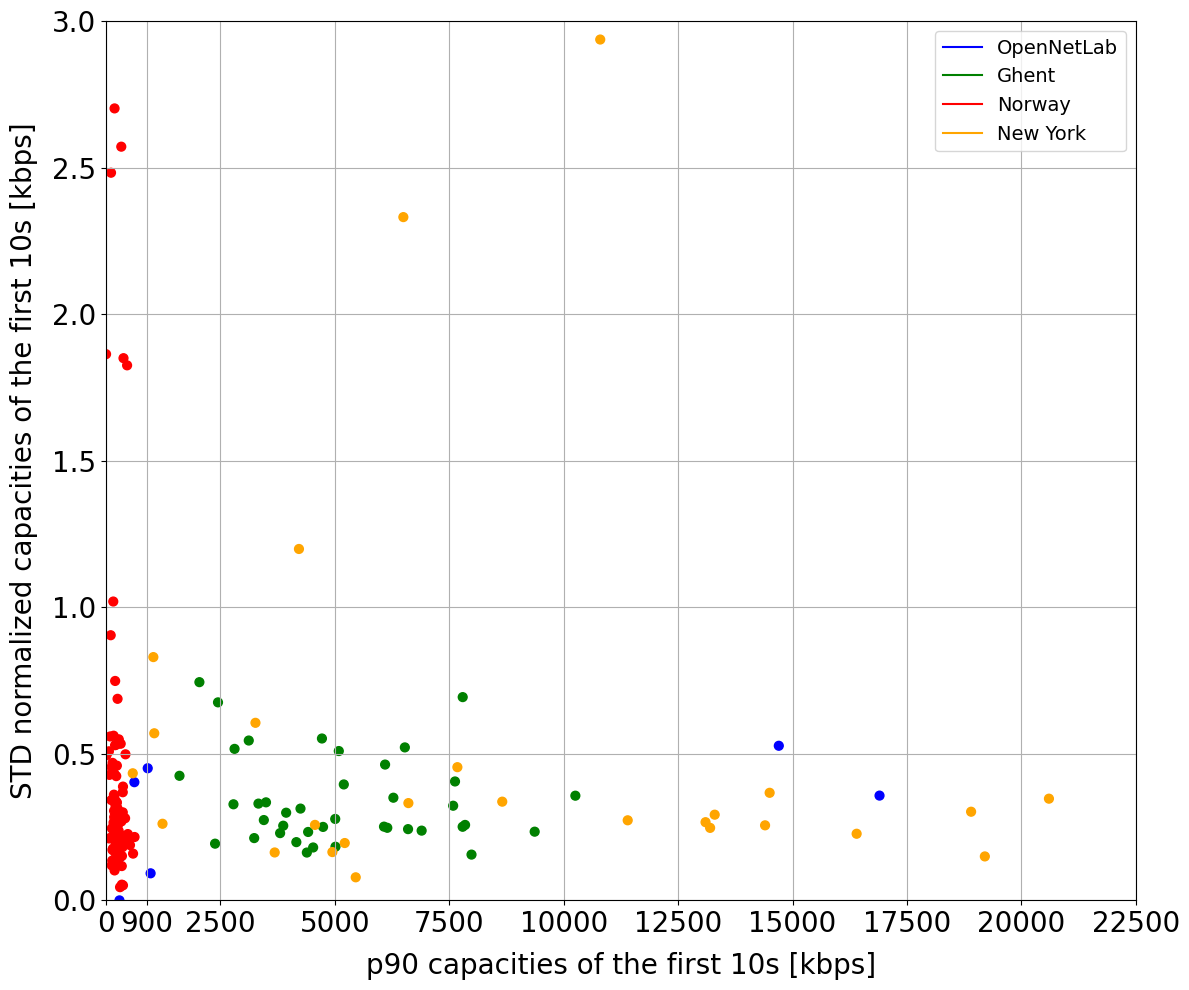

In [73]:
fontsize=20
# fig, ax = plt.subplots(figsize=(12,10))

df.plot.scatter("p90_first_10s", "std_norm_first_10s", s=40, c="color", figsize=(12,10))
plt.xlim(0,22000)
plt.ylim(0,3)
plt.yticks(fontsize=fontsize)
plt.xticks([ 0, 900, 2500, 5000, 7500, 10000, 12500, 15000, 17500 ,20000, 22500], [ 0, 900, 2500, 5000, 7500, 10000, 12500, 15000, 17500 ,20000, 22500], fontsize=fontsize)
# plt.yticks([ 0, 250, 1000, 2000, 3000, 4000, 5000, 6000], [0, 250, 1000, 2000, 3000, 4000, 5000, 6000], fontsize=fontsize)
plt.xlabel("p90 capacities of the first 10s [kbps]", fontsize=fontsize, labelpad=10)
plt.ylabel("STD normalized capacities of the first 10s [kbps]", fontsize=fontsize, labelpad=10)
plt.grid()
legend = get_legend_based_on_dataset()

plt.tight_layout()

plt.savefig(f"plots/p90_vs_std_norm.png")

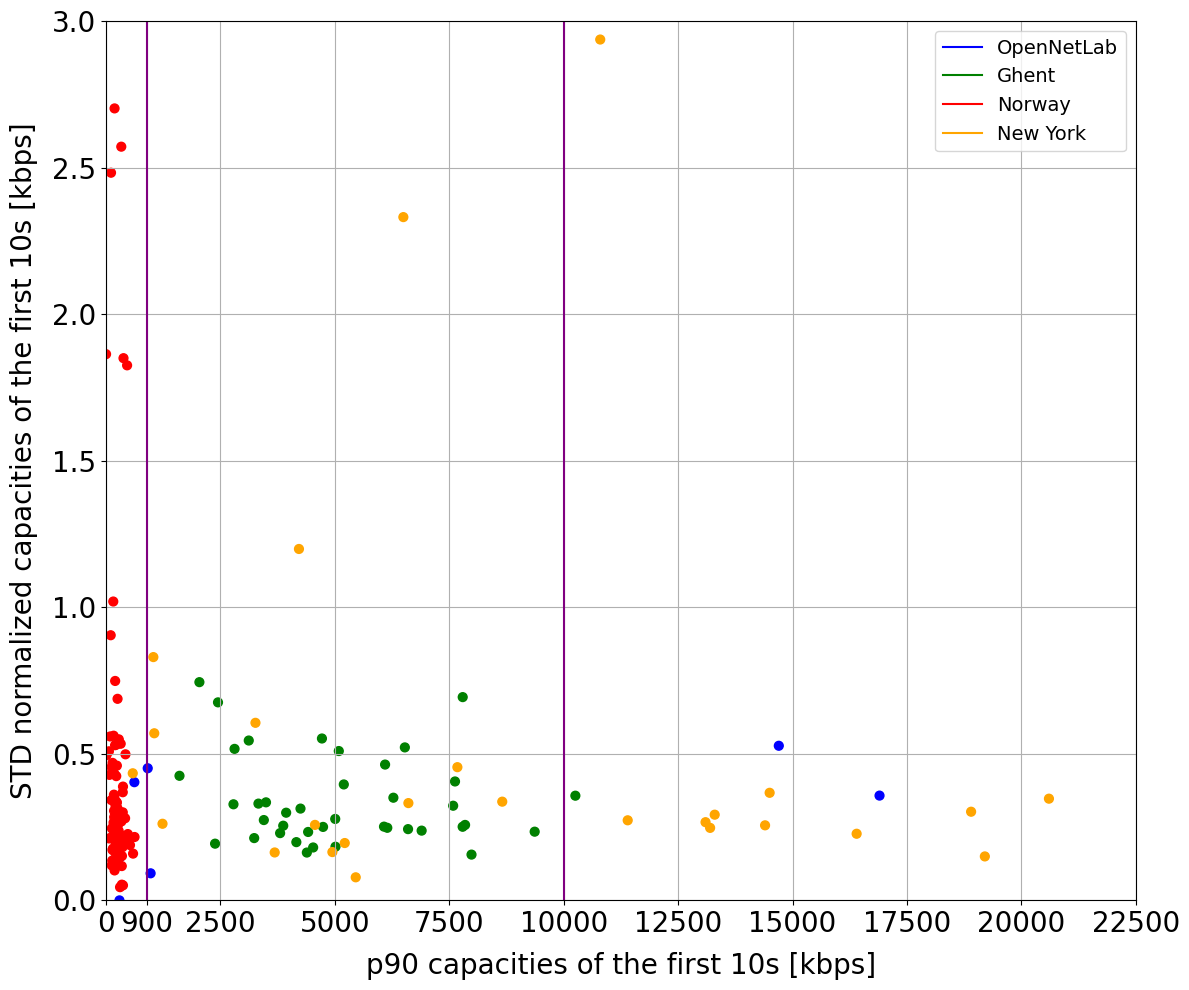

In [81]:
fontsize=20
# fig, ax = plt.subplots(figsize=(12,10))

df.plot.scatter("p90_first_10s", "std_norm_first_10s", s=40, c="color", figsize=(12,10))
plt.xlim(0,22000)
plt.ylim(0,3)
plt.axvline(x=10000, color='purple', linestyle='-')
plt.axvline(x=900, color='purple', linestyle='-')
plt.yticks(fontsize=fontsize)
plt.xticks([ 0, 900, 2500, 5000, 7500, 10000, 12500, 15000, 17500 ,20000, 22500], [ 0, 900, 2500, 5000, 7500, 10000, 12500, 15000, 17500 ,20000, 22500], fontsize=fontsize)
# plt.yticks([ 0, 250, 1000, 2000, 3000, 4000, 5000, 6000], [0, 250, 1000, 2000, 3000, 4000, 5000, 6000], fontsize=fontsize)
plt.xlabel("p90 capacities of the first 10s [kbps]", fontsize=fontsize, labelpad=10)
plt.ylabel("STD normalized capacities of the first 10s [kbps]", fontsize=fontsize, labelpad=10)
plt.grid()
legend = get_legend_based_on_dataset()

plt.tight_layout()

plt.savefig(f"plots/p90_vs_std_norm_thresholds.png")

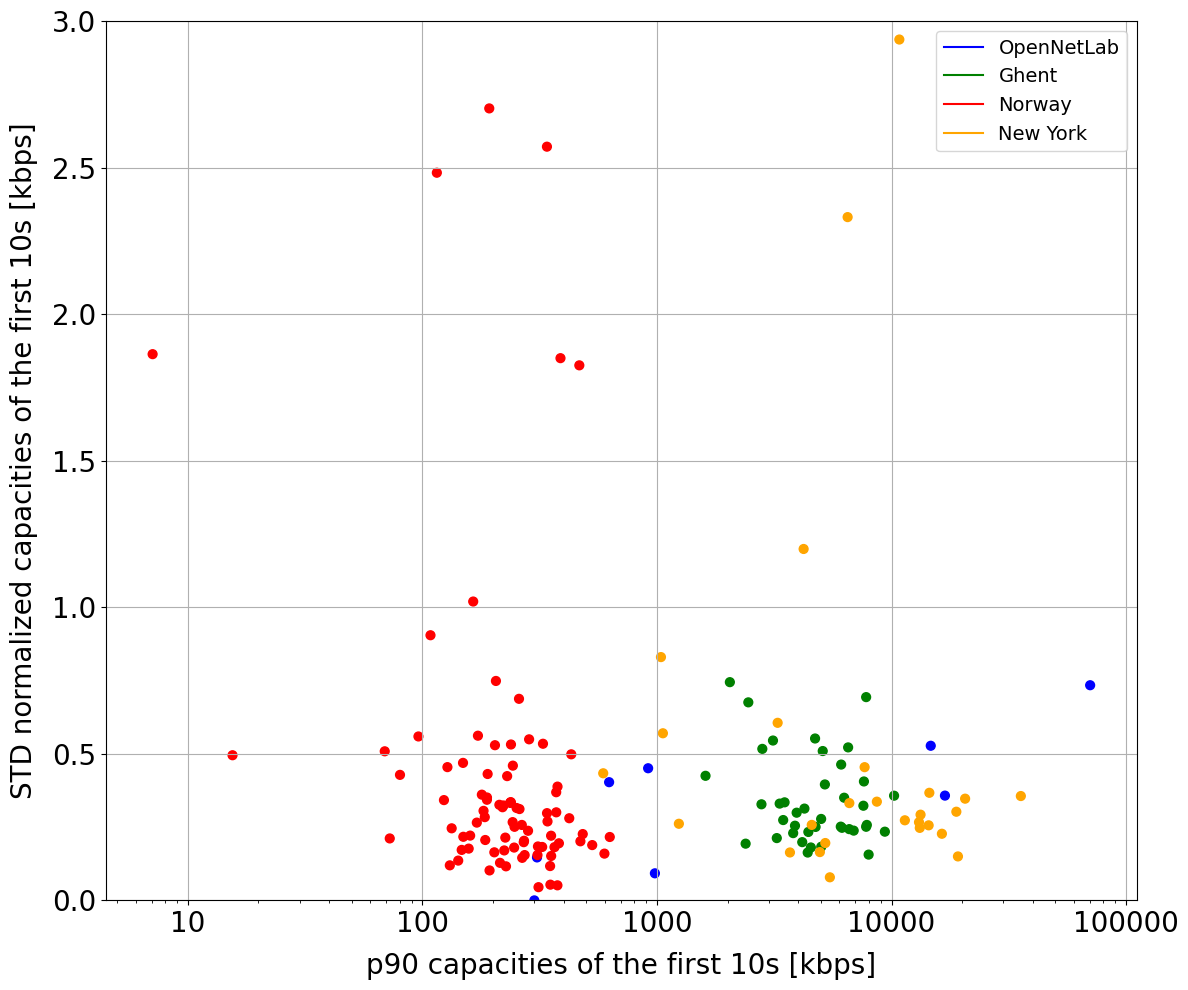

In [10]:
fontsize=20
df.plot.scatter("p90_first_10s", "std_norm_first_10s", s=40, c="color", figsize=(12,10), label="dataset")
plt.xscale("log")
plt.ylim(0,3)

plt.yticks(fontsize=fontsize)
plt.xticks([10,100,1000,10000, 100000],[10,100,1000,10000, 100000] , fontsize=fontsize)
plt.xlabel("p90 capacities of the first 10s [kbps]", fontsize=fontsize, labelpad=10)
plt.ylabel("STD normalized capacities of the first 10s [kbps]", fontsize=fontsize, labelpad=10)
plt.grid()
legend = get_legend_based_on_dataset()

plt.tight_layout()

plt.savefig(f"plots/p90_vs_std_norm_log_scale.png")

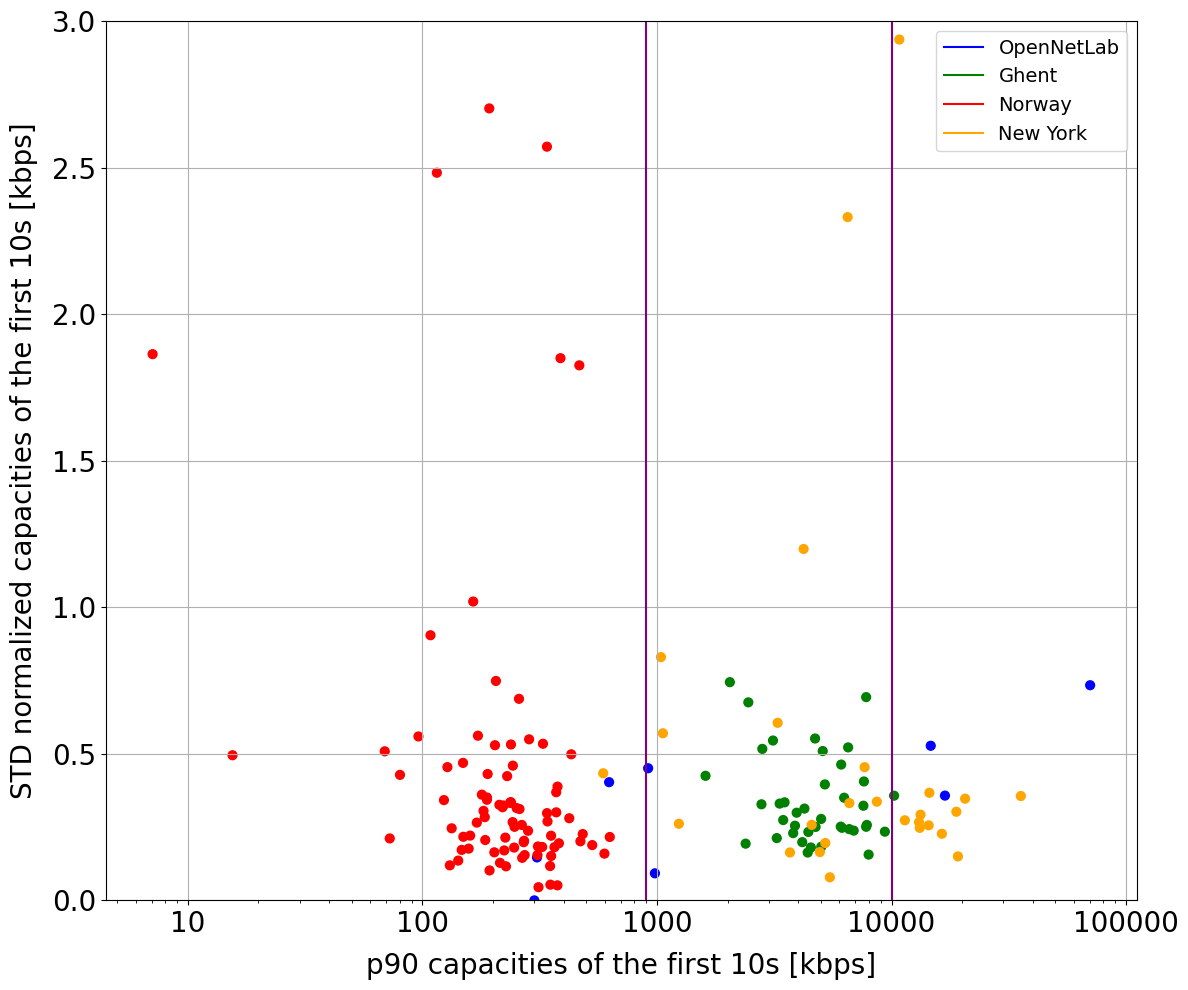

In [11]:
fontsize=20
df.plot.scatter("p90_first_10s", "std_norm_first_10s", s=40, c="color", figsize=(12,10), label="dataset")
plt.xscale("log")
plt.ylim(0,3)
plt.axvline(x=10000, color='purple', linestyle='-')
plt.axvline(x=900, color='purple', linestyle='-')

plt.yticks(fontsize=fontsize)
plt.xticks([10,100,1000,10000, 100000],[10,100,1000,10000, 100000] , fontsize=fontsize)
plt.xlabel("p90 capacities of the first 10s [kbps]", fontsize=fontsize, labelpad=10)
plt.ylabel("STD normalized capacities of the first 10s [kbps]", fontsize=fontsize, labelpad=10)
plt.grid()
legend = get_legend_based_on_dataset()

plt.tight_layout()


plt.savefig(f"plots/p90_vs_std_norm_log_scale_threshold.png")

# Plot CDF of all or some traces

In [86]:
def set_color_based_on_vehicle(label):
    if "car" in label or "Car" in label:
        color = "royalblue"
    elif "bus" in label or "Bus" in label:
        color = "orange"
    elif "foot" in label:
        color = "indianred"
    elif "metro" in label or "subway" in label.lower():
        color = "black"
    elif "train" in label.lower() or "rail" in label.lower():
        color = "green"
    elif "tram" in label:
        color = "lightblue"
    elif "ferry" in label or "Ferry" in label:
        color = "indianred"
    else:
        color = "purple"
        
    return color

def get_legend_based_on_dataset():
    blue_line = mlines.Line2D([], [], color='blue', label='OpenNetLab')
    green_line = mlines.Line2D([], [], color='green', label='Ghent')
    red_line = mlines.Line2D([], [], color='red', label='Norway')
    orange_line = mlines.Line2D([], [], color='orange', label='New York')
    legend = plt.legend(handles=[blue_line, green_line, red_line, orange_line], prop={'size': 14}, ncol=1)
    
    return legend

def get_legend_based_on_threshold():
    blue_line = mlines.Line2D([], [], color='cornflowerblue', label='Low bandwidth')
    green_line = mlines.Line2D([], [], color='mediumseagreen', label='Medium bandwidth')
    red_line = mlines.Line2D([], [], color='indianred', label='High bandwidth')
    legend = plt.legend(handles=[blue_line, green_line, red_line], prop={'size': 14}, ncol=1)
    
    return legend

In [20]:
# SET DATA DIVISION THRESHOLDS
p90_lower_threshold = 0
p90_higher_threshold = 900
std_lower_threshold = 0
std_higher_threshold = 250

Number of traces plotted:  162


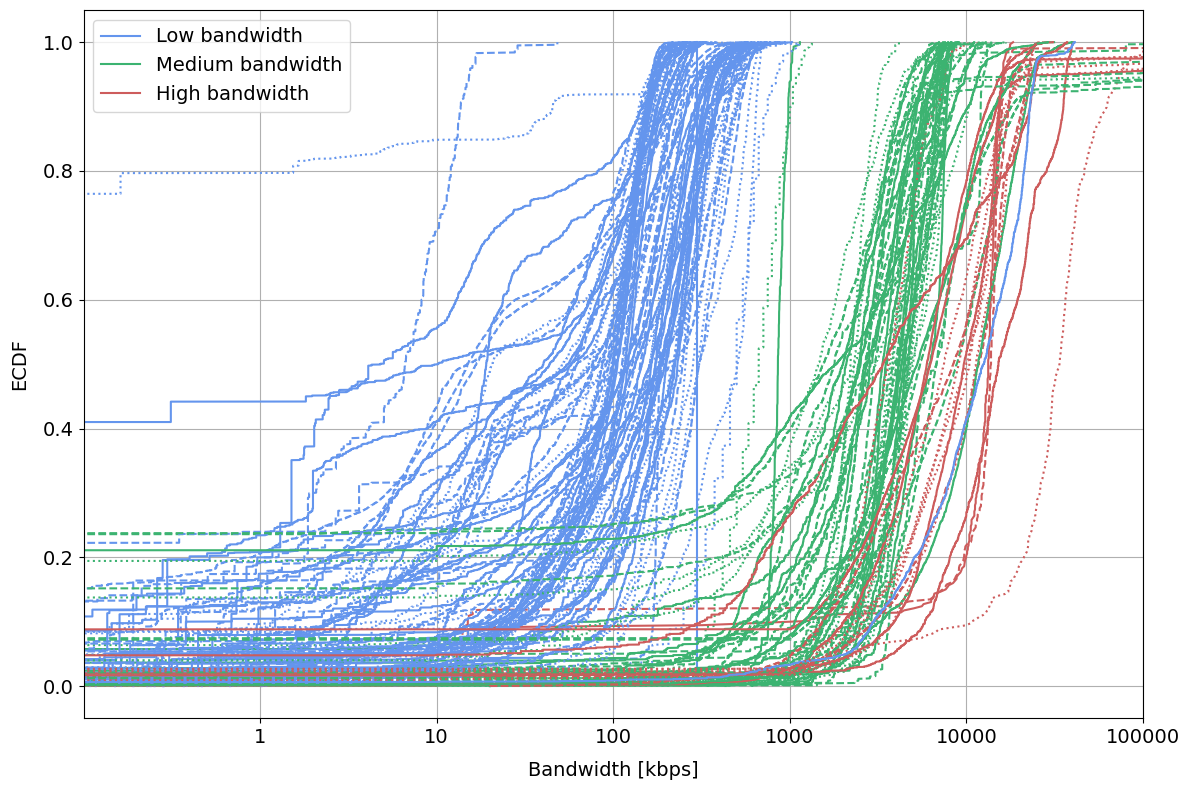

In [101]:
traces_to_train_on = defaultdict(list)

figsize = (12, 8)
labelspacing = 0.2
legend_fontsize = 12
fontsize = 14
x_label = "Bandwidth [kbps]"

colors_dataset = ["#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
linestyles = ["dashed", "solid", "dotted", "dashdot", (0, (3, 1, 1, 1))]
colors_dataset = ["indianred", "teal", "lightgreen"]
cd = itertools.cycle(colors_dataset)

fig, ax = plt.subplots(figsize=figsize)
ax.tick_params(axis='both', which='minor',
               length=0,
               # direction='in'
              )
ax.tick_params(axis='both', which='major',
               #length=0,
               # direction='in'
              )
c = 0

for i in range(len(traces_stats)):

    data = traces_stats[i]["capacities_series"]
    label = os.path.basename(traces_stats[i]["trace"]).split(".")[0]
    legend_params = {"bbox_to_anchor": (1.0,1.0), "loc": 'upper left', "ncol": 2}
    
    if ((traces_stats[i]["p90_first_10s"] >= 0) and (traces_stats[i]["p90_first_10s"] < 900)):
        color = "cornflowerblue"
        key = "low"
    elif ((traces_stats[i]["p90_first_10s"] >= 900) and (traces_stats[i]["p90_first_10s"] < 10000)):
        color = "mediumseagreen"
        key = "medium"
    elif (traces_stats[i]["p90_first_10s"] >= 10000):
        color = "indianred"
        key = "high"
    
        
    traces_to_train_on[key].append(traces_stats[i]["trace_path"])


    #set linestyles
    if c%3 == 0:
        ls = itertools.cycle(linestyles)
    c+=1

    cdfx = np.sort(data)
    cdfy = np.linspace(1 / len(data), 1.0, len(data))

    #plot cdf
    p = plt.plot(cdfx, cdfy,
                 linestyle=next(ls),
                 label=label,
                 color = color
                )
    
    
print("Number of traces plotted: ", c)

plt.xscale('log')
plt.yticks(np.arange(0,1.1,0.2))
ax.tick_params(axis='y', labelsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)

plt.xlabel(x_label, fontsize=fontsize, labelpad=10)
plt.xlim(0.1,100000)
plt.ylabel('ECDF', fontsize=fontsize, labelpad=10)
plt.grid()

plt.xticks([1, 10, 100, 1000, 10000, 100000], [1, 10, 100, 1000, 10000, 100000])
legend = get_legend_based_on_threshold()

plt.tight_layout()


plt.savefig("plots/bandwidth_channel_type_threshold.png",  bbox_inches='tight')
# plt.savefig("plots/bandwidth_all_traces.png",  bbox_inches='tight', dpi=500, transparent=True)

## Print lists to train on

In [98]:
print("High bandwidth: ", len(traces_to_train_on["high"]))
# traces_to_train_on["high"]
["." + t.split("..")[1] for t in traces_to_train_on["high"]]

High bandwidth:  16


['./traces/5G_13mbps.json',
 './traces/5G_12mbps.json',
 './traces/WIRED_35mbps.json',
 './new_data/logs_all_4G_Ghent_json/report_bus_0009.json',
 './new_data/NY_4G_data_json/7Train_7BtrainNew.json',
 './new_data/NY_4G_data_json/Subway_D_Train_d1.json',
 './new_data/NY_4G_data_json/Bus_NYU_Campus_NYU_Campus_Bus.json',
 './new_data/NY_4G_data_json/Bus_M15_M15_2.json',
 './new_data/NY_4G_data_json/Subway_Q_Train_Q_Train3.json',
 './new_data/NY_4G_data_json/Bus_B57_bus57_2.json',
 './new_data/NY_4G_data_json/Subway_D_Train_d2.json',
 './new_data/NY_4G_data_json/Subway_Q_Train_Q_Train2.json',
 './new_data/NY_4G_data_json/Subway_7Train_7Train2.json',
 './new_data/NY_4G_data_json/Car_Car_2.json',
 './new_data/NY_4G_data_json/BusBrooklyn_bus57New.json',
 './new_data/NY_4G_data_json/Subway_Q_Train_Q_Train1.json']

In [99]:
print("Medium bandwidth: ", len(traces_to_train_on["medium"]))
["." + t.split("..")[1] for t in traces_to_train_on["medium"]]

Medium bandwidth:  56


['./traces/4G_3mbps.json',
 './traces/WIRED_900kbps.json',
 './traces/4G_700kbps.json',
 './new_data/logs_all_4G_Ghent_json/report_bus_0004.json',
 './new_data/logs_all_4G_Ghent_json/report_car_0001.json',
 './new_data/logs_all_4G_Ghent_json/report_car_0007.json',
 './new_data/logs_all_4G_Ghent_json/report_car_0006.json',
 './new_data/logs_all_4G_Ghent_json/report_foot_0002.json',
 './new_data/logs_all_4G_Ghent_json/report_foot_0005.json',
 './new_data/logs_all_4G_Ghent_json/report_tram_0007.json',
 './new_data/logs_all_4G_Ghent_json/report_train_0003.json',
 './new_data/logs_all_4G_Ghent_json/report_bicycle_0001.json',
 './new_data/logs_all_4G_Ghent_json/report_tram_0003.json',
 './new_data/logs_all_4G_Ghent_json/report_bus_0001.json',
 './new_data/logs_all_4G_Ghent_json/report_tram_0006.json',
 './new_data/logs_all_4G_Ghent_json/report_car_0008.json',
 './new_data/logs_all_4G_Ghent_json/report_bus_0010.json',
 './new_data/logs_all_4G_Ghent_json/report_tram_0005.json',
 './new_data/lo

In [100]:
print("Low bandwidth: ", len(traces_to_train_on["low"]))
["." + t.split("..")[1] for t in traces_to_train_on["low"]]

Low bandwidth:  90


['./traces/trace_300k.json',
 './traces/4G_500kbps.json',
 './traces/WIRED_200kbps.json',
 './new_data/Norway_3G_data_json/tram_2010-12-22_0800CET.json',
 './new_data/Norway_3G_data_json/tram_2011-01-04_0820CET.json',
 './new_data/Norway_3G_data_json/metro_2010-09-14_1038CEST.json',
 './new_data/Norway_3G_data_json/ferry_2010-09-21_1622CEST.json',
 './new_data/Norway_3G_data_json/metro_2010-10-18_0951CEST.json',
 './new_data/Norway_3G_data_json/train_2011-02-14_1728CET.json',
 './new_data/Norway_3G_data_json/metro_2010-09-14_2303CEST.json',
 './new_data/Norway_3G_data_json/tram_2010-12-22_0849CET.json',
 './new_data/Norway_3G_data_json/bus_2010-11-10_1726CET.json',
 './new_data/Norway_3G_data_json/bus_2011-01-31_1025CET.json',
 './new_data/Norway_3G_data_json/bus_2010-11-10_1424CET.json',
 './new_data/Norway_3G_data_json/tram_2010-12-09_1334CET.json',
 './new_data/Norway_3G_data_json/tram_2010-12-21_1225CET.json',
 './new_data/Norway_3G_data_json/bus_2010-09-30_1114CEST.json',
 './new_